In [1]:
%load_ext autoreload
%autoreload 2

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loader" data-toc-modified-id="Data-loader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loader</a></span></li></ul></div>

In [2]:
from data_handlers.data_preparer import get_datasets
import torch
from typing import Dict
from viewer import Viewer
import os

In [3]:
from PIL import Image

# Train loop

In [4]:
from models import Net

In [5]:
from data_handlers.data_preparer import get_datasets

In [6]:
datasets = get_datasets()

Found annotations at '/mnt/heap/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [22.4s elapsed, 0s remaining, 211.7 samples/s]      
Dataset 'coco-2017-validation' created
person_view len = 1005
train dataset = 753
test dataset = 252


In [7]:
def get_loaders(datasets) -> Dict[str,  torch.utils.data.DataLoader]:
    return {
        'train': torch.utils.data.DataLoader(
            datasets['train'], batch_size=64, shuffle=True),
        'val': torch.utils.data.DataLoader(
            datasets['val'], batch_size=64, shuffle=False)
    }

In [8]:
loaders = get_loaders(datasets)

In [9]:
viewer = Viewer()

In [10]:
datasets['train'][0]

(tensor([[[0.7922, 0.8000, 0.8000,  ..., 0.7529, 0.7490, 0.7412],
          [0.7686, 0.7882, 0.8039,  ..., 0.7412, 0.7490, 0.7412],
          [0.7804, 0.7765, 0.7882,  ..., 0.7373, 0.7490, 0.7333],
          ...,
          [0.7725, 0.7569, 0.7608,  ..., 0.8196, 0.8275, 0.8353],
          [0.7647, 0.7647, 0.7569,  ..., 0.8235, 0.8235, 0.8314],
          [0.7529, 0.7725, 0.7686,  ..., 0.8353, 0.8353, 0.8353]],
 
         [[0.7765, 0.7843, 0.7804,  ..., 0.7333, 0.7294, 0.7216],
          [0.7529, 0.7686, 0.7804,  ..., 0.7255, 0.7373, 0.7255],
          [0.7608, 0.7569, 0.7686,  ..., 0.7255, 0.7373, 0.7216],
          ...,
          [0.7569, 0.7569, 0.7608,  ..., 0.8118, 0.8196, 0.8275],
          [0.7569, 0.7608, 0.7529,  ..., 0.8157, 0.8118, 0.8157],
          [0.7490, 0.7686, 0.7647,  ..., 0.8275, 0.8235, 0.8196]],
 
         [[0.7765, 0.7882, 0.7882,  ..., 0.7608, 0.7529, 0.7451],
          [0.7647, 0.7804, 0.7882,  ..., 0.7529, 0.7608, 0.7529],
          [0.7804, 0.7725, 0.7765,  ...,

In [18]:
checkpoint_dir = '/mnt/heap/My folder/tune_reports/experiment_name/find_hyperparameters_32f52_00000_0_2022-02-22_16-24-13/checkpoint_000004'

In [19]:
torch_model = Net()

In [20]:
checkpoint = os.path.join(checkpoint_dir, "checkpoint")
model_state, optimizer_state = torch.load(checkpoint)
torch_model.load_state_dict(model_state)

<All keys matched successfully>

torch_model = Net()

In [21]:
def predict(index):
    img, target = datasets['train'][index]
    pred = torch_model(img.unsqueeze(0))
    print('pred = {}, target = {}'.format(pred['bbox'], target['box']))
    
    original_img = Image.open(target['img_path']).convert("RGB")
    viewer.print_prediction(original_img, target, pred)

pred = tensor([[1.0753e-07, 4.7873e-03, 9.9974e-01, 1.0000e+00]],
       grad_fn=<SliceBackward0>), target = tensor([0.2292, 0.5595, 0.3871, 0.7325])


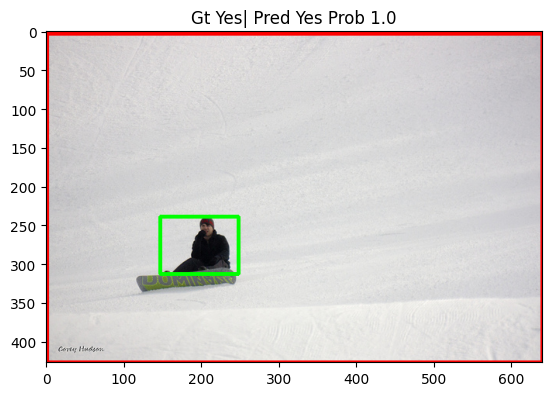

pred = tensor([[2.2422e-08, 2.9812e-03, 9.9988e-01, 1.0000e+00]],
       grad_fn=<SliceBackward0>), target = tensor([0.4524, 0.4771, 0.5553, 0.8022])


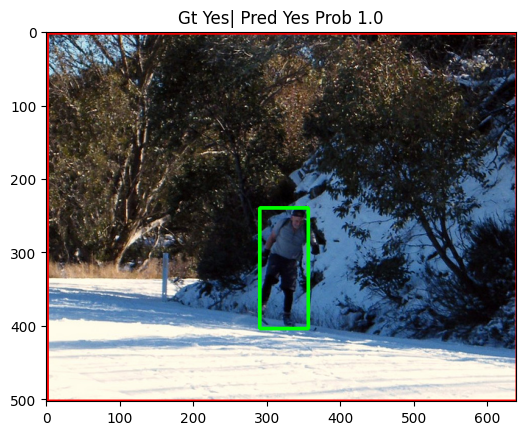

pred = tensor([[2.2664e-07, 6.0935e-03, 9.9961e-01, 1.0000e+00]],
       grad_fn=<SliceBackward0>), target = tensor([0.0912, 0.1146, 0.7883, 0.7918])


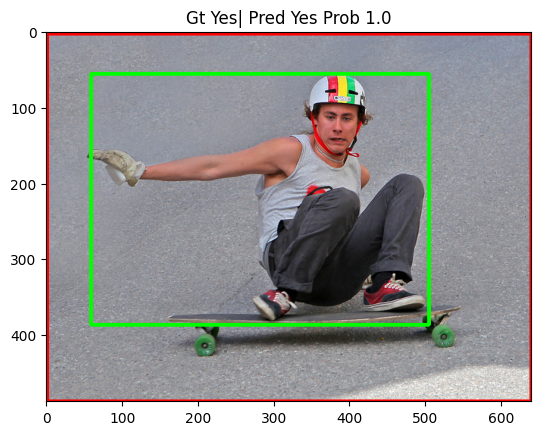

pred = tensor([[4.1371e-08, 3.5576e-03, 9.9983e-01, 1.0000e+00]],
       grad_fn=<SliceBackward0>), target = tensor([0.2617, 0.1258, 0.6953, 0.6697])


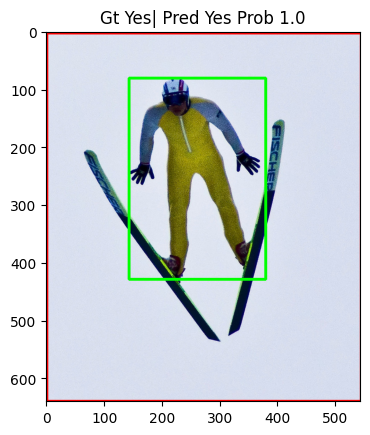

pred = tensor([[6.3614e-08, 4.0899e-03, 9.9979e-01, 1.0000e+00]],
       grad_fn=<SliceBackward0>), target = tensor([0.0000, 0.5844, 0.2006, 0.9870])


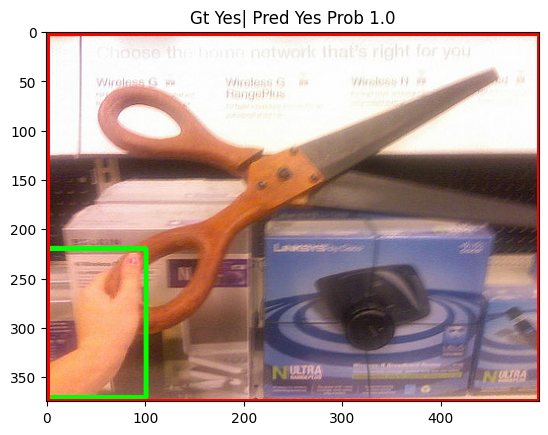

pred = tensor([[9.0532e-08, 4.5751e-03, 9.9975e-01, 1.0000e+00]],
       grad_fn=<SliceBackward0>), target = tensor([0.3778, 0.1798, 0.5098, 0.6989])


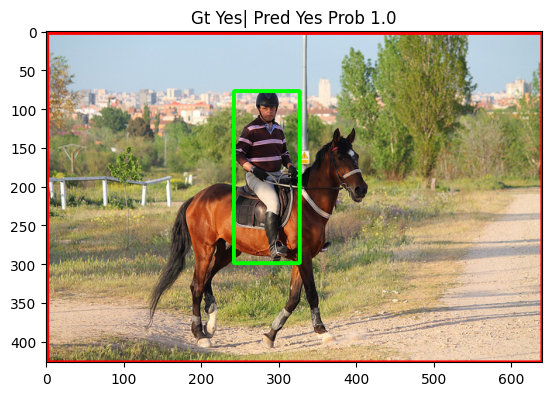

pred = tensor([[2.9326e-07, 6.6473e-03, 9.9955e-01, 1.0000e+00]],
       grad_fn=<SliceBackward0>), target = tensor([0., 0., 0., 0.])


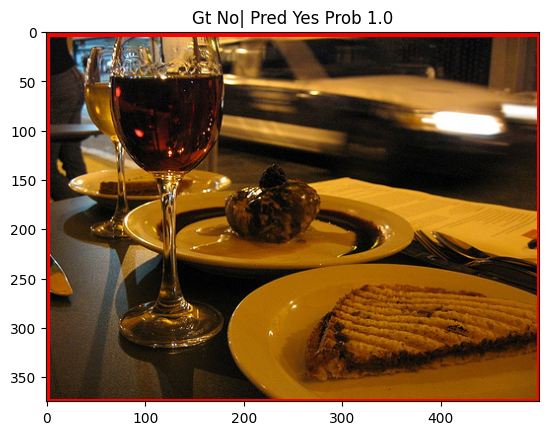

pred = tensor([[2.1375e-07, 6.0221e-03, 9.9964e-01, 1.0000e+00]],
       grad_fn=<SliceBackward0>), target = tensor([0.3691, 0.1213, 1.0000, 0.9881])


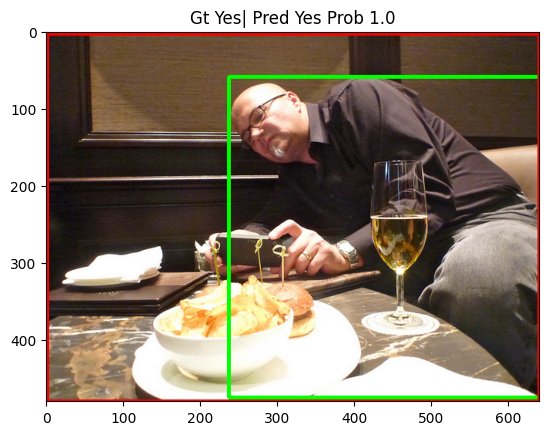

pred = tensor([[1.3759e-07, 5.2256e-03, 9.9970e-01, 1.0000e+00]],
       grad_fn=<SliceBackward0>), target = tensor([0.3771, 0.5624, 0.4189, 0.7434])


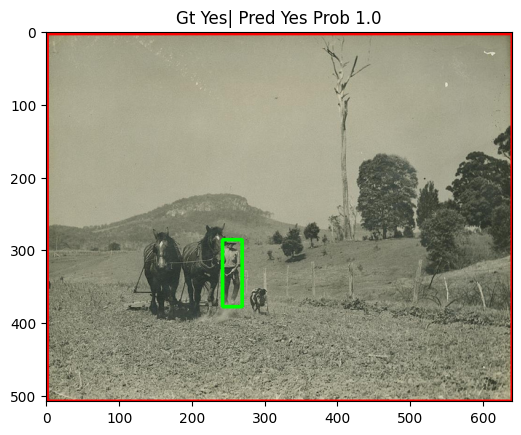

pred = tensor([[1.0641e-07, 4.6763e-03, 9.9974e-01, 1.0000e+00]],
       grad_fn=<SliceBackward0>), target = tensor([0.1650, 0.2446, 0.2851, 0.6645])


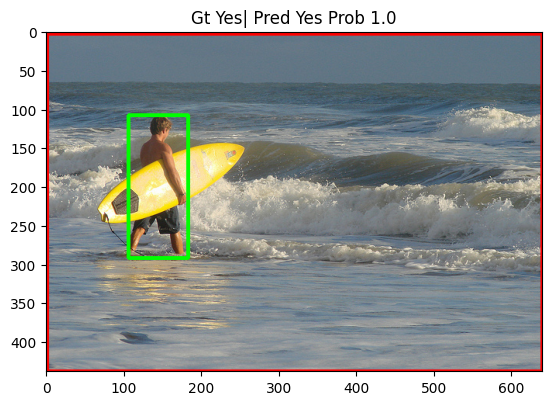

In [26]:
for i in range(10):
    predict(i)

In [23]:
a = [1.3453e-07, 5.0985e-03, 9.9974e-01, 1.0000e+00]

In [ ]:
a